# Q1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


## A

In [2]:
finance = pd.read_csv("finance_popularity.csv")

In [3]:
def preprocess_and_plot(df, col = "month", freq='MS', title = "Finance Search Trends",
                        xlabel = 'Year', ylabel = 'Relative Search Interest', start = "", end = ""):
    df[col] = pd.date_range(start = df[col][0] if start == "" else start,
                            end = df[col].to_numpy()[-1]  if end == "" else end, freq=freq)
    df.set_index(col, inplace = True)
    df.plot(figsize = (8,5))
    plt.title(title,fontsize=15)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.show()
    return df

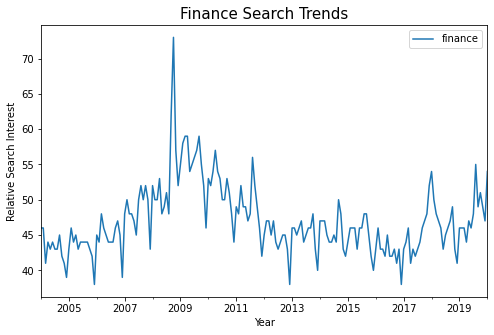

In [4]:
finance = preprocess_and_plot(finance)

there seems to be a seasonality of 12 months according to the local bottom then a local peak at the start of each year, thus the data is not stationary

## B

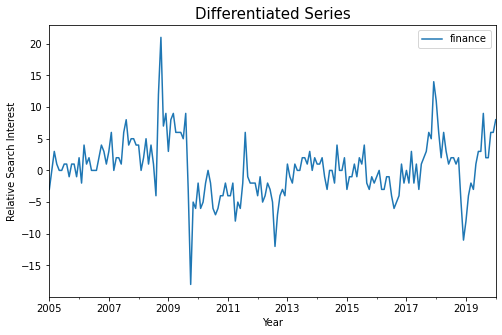

In [5]:
def plot_diff_series(df = finance, periods=12, xlabel= "Year", ylabel = 'Relative Search Interest'):
    df_diff=df.diff(periods=periods)
    df_diff=df_diff.dropna() 

    df_diff.plot(figsize = (8,5))
    plt.title("Differentiated Series",fontsize=15)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    return df_diff
finance_year_diff = plot_diff_series()

we removed the yearly seasonality and also we can see that there is no trend as the data is disributed around 0 therefore the data is stationary

## C

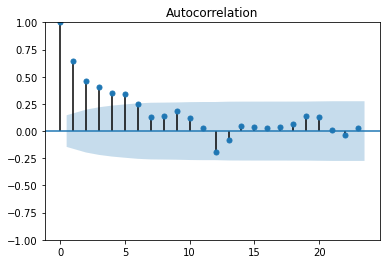

In [6]:
tsaplots.plot_acf(finance_year_diff);

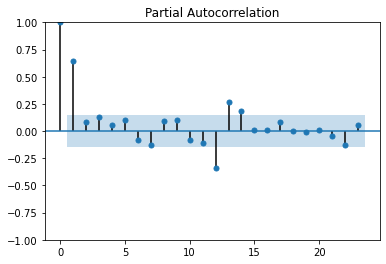

In [7]:
tsaplots.plot_pacf(finance_year_diff);

the pacf is around zero at 3 or more lags, thus we can assume that a good model would be $AR(2)$ or $SARIMA(2,0,0)(1,1,0)_{12}$

## D

### $SARIMA(2,0,0)(1,1,0)_{12}$

In [8]:
def fit_summarize_sarima(data ,order, seasonal_order = (0,0,0,0)):
    sarima_model = SARIMAX(data, order=order,seasonal_order=seasonal_order, freq="MS")                             
    sarima_model_fit = sarima_model.fit(disp=False)
    display(sarima_model_fit.summary())
fit_summarize_sarima(finance, (2, 0, 0), (1,1,0,12))    

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            finance   No. Observations:                  193
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -464.106
Date:                            Wed, 14 Feb 2024   AIC                            936.212
Time:                                    13:03:29   BIC                            949.006
Sample:                                01-01-2004   HQIC                           941.399
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5935      0.044     13.570      0.000       0.508       0.679
ar.L2          0.1923      0.063      3.075      0.002       0.070       0.315
ar.S.L12      -0.4594      0.044    -10.479      0.000      -0.545      -0.373
sigma2         9.6836      0.661     14.648      0.000       8.388      10.979
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               175.39
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                             0.76
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### $AR(2)$

In [9]:
fit_summarize_sarima(finance, (2, 0, 0))    

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                finance   No. Observations:                  193
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -514.193
Date:                Wed, 14 Feb 2024   AIC                           1034.386
Time:                        13:03:29   BIC                           1044.174
Sample:                    01-01-2004   HQIC                          1038.350
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8166      0.038     21.481      0.000       0.742       0.891
ar.L2          0.1813      0.039      4.674      0.000       0.105       0.257
sigma2        11.7378      0.776     15.125      0.000      10.217      13.259
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):                66.56
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## E

the $SARIMA(2,0,0)(1,1,0)_{12}$ model has a better AIC and BIC so we will choose this as our model, lets try to forcast the last year data (without fitting on it) to check how the model works.

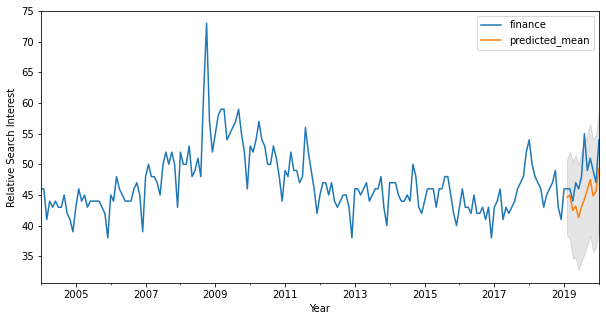

In [10]:
def forecast_with_sarimax(time_series, forecast_periods, order, seasonal_order, xlabel = 'Year',
                          ylabel = 'Relative Search Interest', freq='MS', plot=True, offset = 0, title = "", forcast_next = False):
    if forcast_next:
        sarima_model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
    else:
        sarima_model = SARIMAX(time_series[:-forecast_periods - offset], order=order, seasonal_order=seasonal_order)
    sarima_model_fit = sarima_model.fit(disp=False)

    next_periods_forecast = sarima_model_fit.get_forecast(steps=forecast_periods)
    next_periods_ci = next_periods_forecast.conf_int()
    
    if forcast_next:
        future_dates = pd.date_range(start=time_series.index[-1], periods=forecast_periods, freq=freq)
    else:
        future_dates = pd.date_range(start=time_series.index[-forecast_periods - offset], periods=forecast_periods, freq=freq)
    next_periods_ci.index = future_dates

    futureDF_forecast = pd.DataFrame(next_periods_forecast.predicted_mean, index=future_dates)

    if plot:
        if offset == 0:
            ax = time_series.plot(label='Observed', figsize=(10, 5))
        else:
            ax = time_series[:-offset].plot(label='Observed', figsize=(10, 5))
        futureDF_forecast.plot(ax=ax, label='Forecast', legend=True)
        
        ax.fill_between(next_periods_ci.index,
                        next_periods_ci.iloc[:, 0],
                        next_periods_ci.iloc[:, 1], color='k', alpha=.1)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        plt.legend()
        plt.show()
    return futureDF_forecast, next_periods_ci


future_finance_forecast, next_periods_ci = forecast_with_sarimax(finance, 12, order=(2, 0, 0),seasonal_order=(1, 1, 0,12))

a one data sample for checking the model is rather low, lets create a loop to try several years

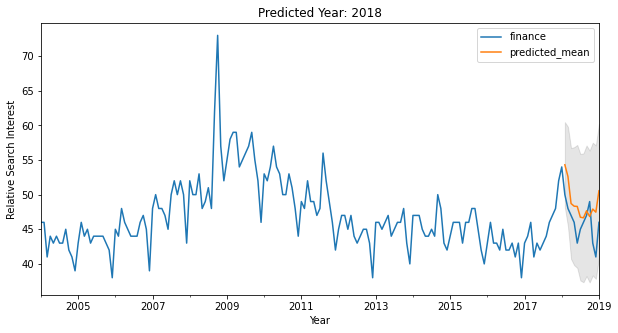

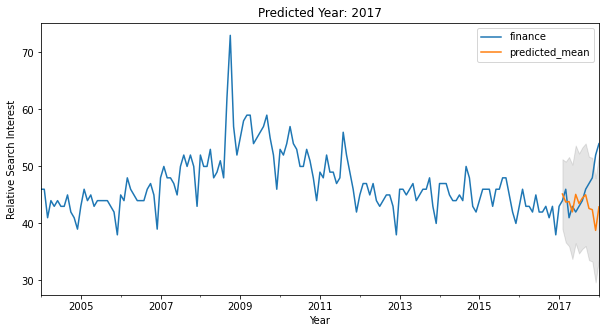

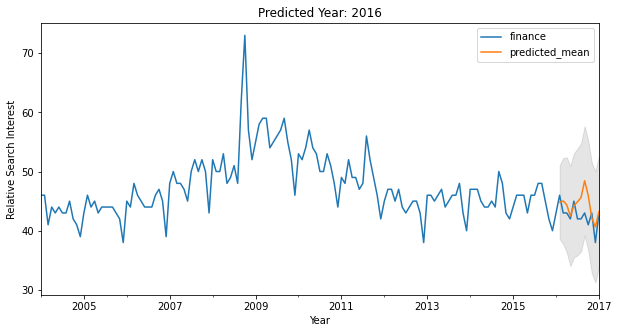

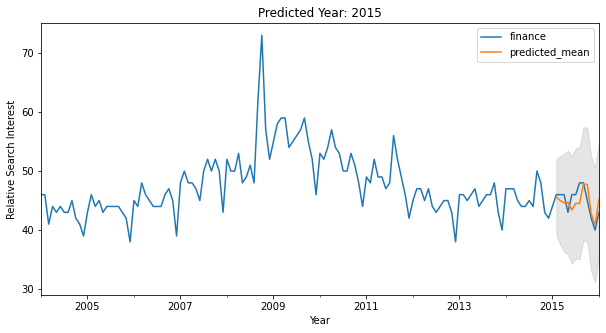

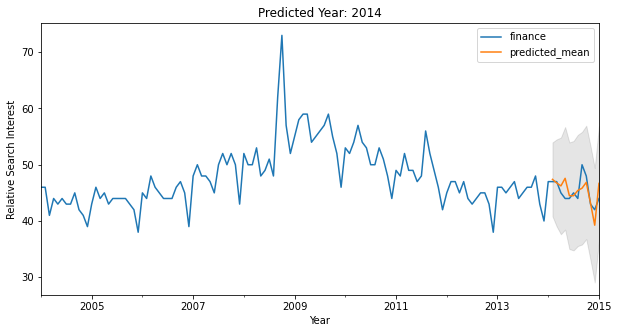

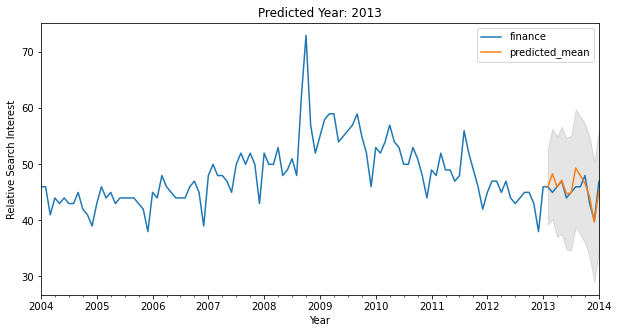

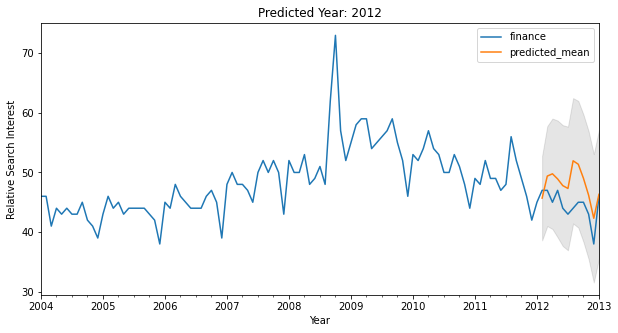

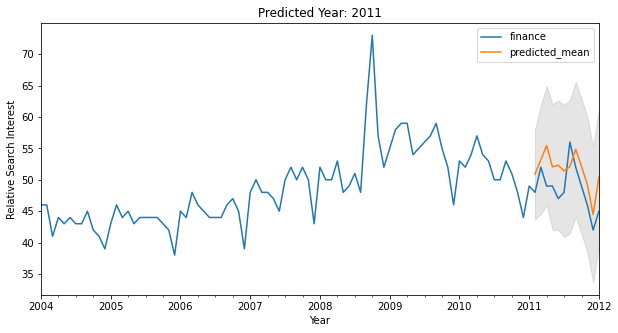

In [11]:
FORECAST = 12
OFFSET = 12
for year, OFFSET in zip(range(2018, 2010, -1), range(12, 9*12,12)):
    future_finance_forecast, next_periods_ci = forecast_with_sarimax(finance, FORECAST, order=(2, 0, 0),seasonal_order=(1, 1, 0,12),
                                                                    offset = OFFSET, title = f"Predicted Year: {year}")

the model seem to work quite well, i tried some different models but did not get much better AIC, BIC and plots

# Q2

## A

In [12]:
baseball = pd.read_csv("baseball_popularity.csv")

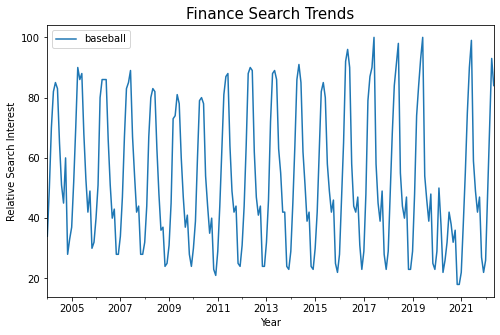

In [13]:
baseball = preprocess_and_plot(baseball)

this time series also looks seasonal without a trend, thus it is not stationary. baseball season usually starts at march\april and ends at october, so we can expect a 12 month seasonality

taking a look at the first 2 years

Text(0, 0.5, 'Relative Search Interest')

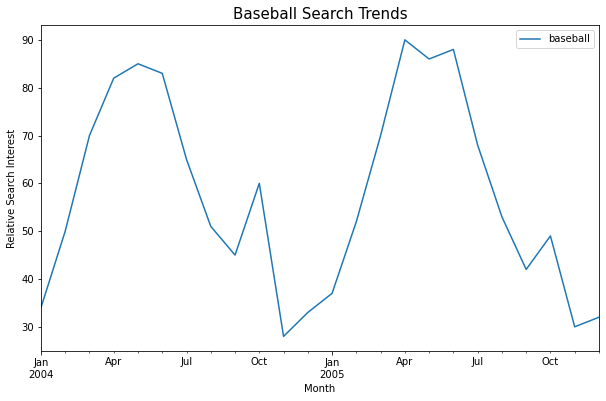

In [14]:
baseball[:24].plot(figsize = (10,6))
plt.title("Baseball Search Trends",fontsize=15)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Relative Search Interest', fontsize=10)

we can see a peak at the start of the season that a slowly decays, until another local peak at october probably due to the finals.

## B

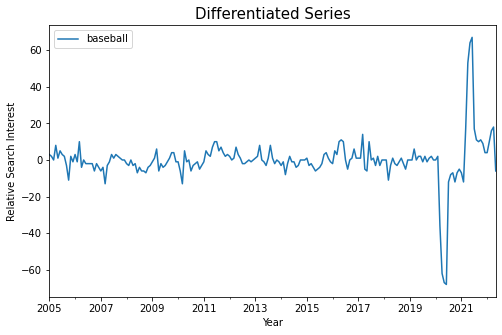

In [15]:
baseball_year_diff = plot_diff_series(baseball)

looks stationary, except for the major noise at 2020-2021 (corona)?

## C

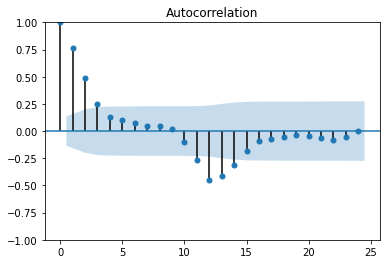

In [16]:
tsaplots.plot_acf(baseball_year_diff);

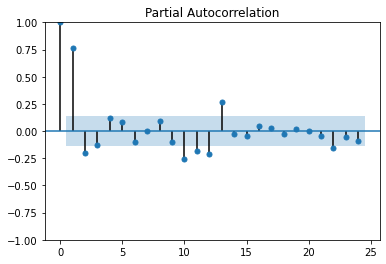

In [17]:
tsaplots.plot_pacf(baseball_year_diff);

the graphs suggests a strong correlation between the last 2 lags and maybe the third lag but also for the lags a year ago, so we can assume that a good model would be $AR(2)$ or $AR(3)$ $SARIMA(2,0,0)(1,1,0)_{12}$ or $SARIMA(2,0,0)(2,1,0)_{12}$, or even maybe Holt Winter’s Exponential Smoothing with 12 months seasonality

## D

### $SARIMA(2,0,0)(1,1,0)_{12}$

In [18]:
fit_summarize_sarima(baseball, (2,0,0), (1,1,0,12))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           baseball   No. Observations:                  221
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -696.006
Date:                            Wed, 14 Feb 2024   AIC                           1400.013
Time:                                    13:03:32   BIC                           1413.382
Sample:                                01-01-2004   HQIC                          1405.418
                                     - 05-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9349      0.034     27.439      0.000       0.868       1.002
ar.L2         -0.2219      0.041     -5.461      0.000      -0.302      -0.142
ar.S.L12      -0.5296      0.035    -15.308      0.000      -0.597      -0.462
sigma2        44.6508      2.200     20.292      0.000      40.338      48.963
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               759.63
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               5.23   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### $SARIMA(2,0,0)(2,1,0)_{12}$

In [19]:
fit_summarize_sarima(baseball, (2,0,0), (2,1,0,12))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           baseball   No. Observations:                  221
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -690.039
Date:                            Wed, 14 Feb 2024   AIC                           1390.078
Time:                                    13:03:33   BIC                           1406.790
Sample:                                01-01-2004   HQIC                          1396.835
                                     - 05-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8810      0.036     24.285      0.000       0.810       0.952
ar.L2         -0.1692      0.045     -3.794      0.000      -0.257      -0.082
ar.S.L12      -0.6692      0.057    -11.748      0.000      -0.781      -0.558
ar.S.L24      -0.3245      0.067     -4.821      0.000      -0.456      -0.193
sigma2        41.7372      1.940     21.519      0.000      37.936      45.539
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1060.91
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               5.87   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### $AR(2)$

In [20]:
fit_summarize_sarima(baseball, (2,0,0))

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               baseball   No. Observations:                  221
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -885.737
Date:                Wed, 14 Feb 2024   AIC                           1777.474
Time:                        13:03:33   BIC                           1787.669
Sample:                    01-01-2004   HQIC                          1781.591
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3758      0.075     18.277      0.000       1.228       1.523
ar.L2         -0.4219      0.083     -5.105      0.000      -0.584      -0.260
sigma2       174.7732     19.362      9.027      0.000     136.825     212.722
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):                62.03
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                            -1.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### $AR(3)$

In [21]:
fit_summarize_sarima(baseball, (3,0,0))

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               baseball   No. Observations:                  221
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -885.468
Date:                Wed, 14 Feb 2024   AIC                           1778.937
Time:                        13:03:33   BIC                           1792.529
Sample:                    01-01-2004   HQIC                          1784.425
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3550      0.081     16.675      0.000       1.196       1.514
ar.L2         -0.3535      0.148     -2.392      0.017      -0.643      -0.064
ar.L3         -0.0499      0.101     -0.496      0.620      -0.247       0.147
sigma2       174.2810     19.538      8.920      0.000     135.987     212.575
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                62.61
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.83   Skew:                            -1.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Prophet

13:03:33 - cmdstanpy - INFO - Chain [1] start processing
13:03:33 - cmdstanpy - INFO - Chain [1] done processing


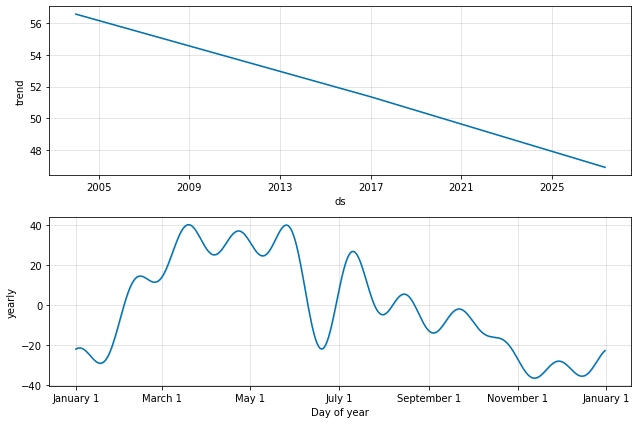

In [22]:
baseball_prophet = baseball.reset_index().rename({"month": "ds", "baseball": "y"}, axis =1)
m = Prophet()
m.fit(baseball_prophet)
future_dates = m.make_future_dataframe(periods=60, freq='MS')
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);

we can see that there is indeed yearly seasonality April-June seem to be the time when people usually search baseball. we also see a linear decreasing trend

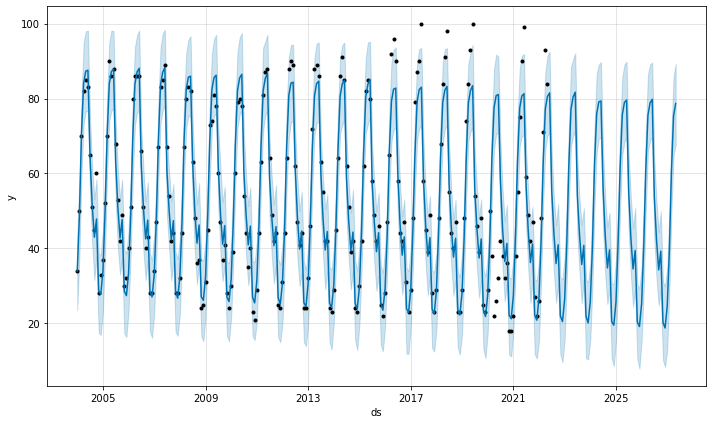

In [23]:
m.plot(forecast);

### HWES

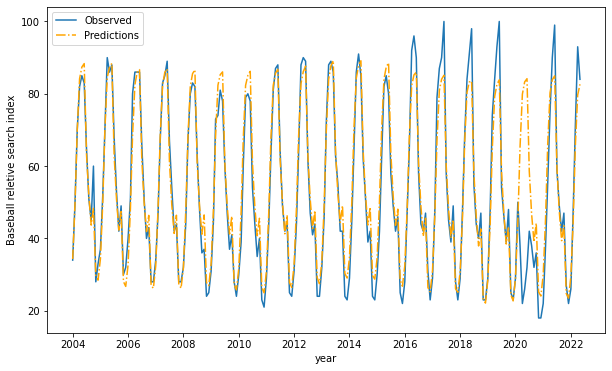

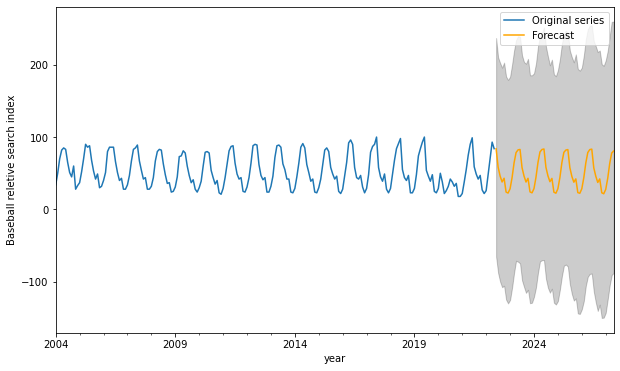

In [24]:
import matplotlib.pyplot as plt

def plot_observed_predictions(data, preds, forecast_len, ylabel='', xlabel=''):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(data.index, data, label="Observed")
    ax.plot(data.index, preds[:-forecast_len], color="orange", ls = "-.", label="Predictions")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend()
    plt.show()

def plot_forecast_with_confidence_intervals(data, preds, upper_ci, lower_ci, ylabel='', xlabel=''):
    ax = data.plot(label="Original series", figsize=(10, 6))
    preds.plot(label="Forecast", color="orange", ax=ax)
    ax.fill_between(upper_ci.index, upper_ci, lower_ci, color='k', alpha=.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.legend()
    plt.show()

def simulate_ets_predictions(data, column_name, seasonal='add', trend='add', seasonal_periods=12, n_repetitions=500,
                             forecast_len=60, plot_obs_pred=True, ylabel='', xlabel="", plot_org_forecast=True):  
    ets_model = ETSModel(
        endog=data[column_name],
        seasonal=seasonal,
        trend=trend,
        seasonal_periods=seasonal_periods)
    ets_result = ets_model.fit()

    # Simulate predictions.
    n_steps_prediction = data[column_name].shape[0]

    df_simul = ets_result.simulate(
        nsimulations=n_steps_prediction+forecast_len,
        repetitions=n_repetitions,
        anchor='start',
    )
    preds = df_simul.mean(axis=1)
    # Calculate confidence intervals.
    upper_ci = df_simul.quantile(q=0.95, axis='columns')
    lower_ci = df_simul.quantile(q=0.05, axis='columns')
    
    if plot_obs_pred:
        plot_observed_predictions(data[column_name], preds, forecast_len, ylabel, xlabel)

    if plot_org_forecast:
        plot_forecast_with_confidence_intervals(data[column_name], preds[-forecast_len:],
                                                upper_ci[-forecast_len:], lower_ci[-forecast_len:], ylabel, xlabel)

    return preds, lower_ci, upper_ci

preds, lower_ci, upper_ci = simulate_ets_predictions(baseball, "baseball",
                                                     ylabel = 'Baseball reletive search index', xlabel="year")




## E

$SARIMA(2,0,0)(2,1,0)_{12}$ has the best AIC and BIC (excluding prophet and HWES)

prophet and HWES have a smilar fit based on the graphs

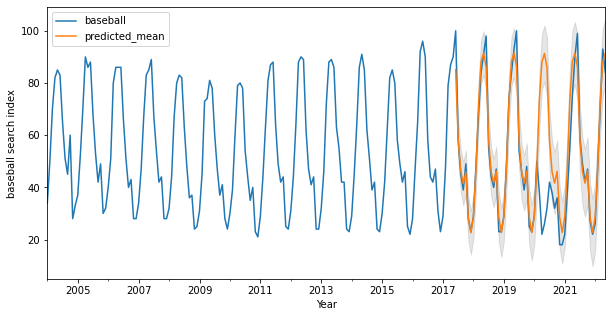

In [25]:
_,_ = forecast_with_sarimax(baseball, 60, order=(2, 0, 0),seasonal_order=(2, 1, 0,12), ylabel = "baseball search index")

$SARIMA(2,0,0)(2,1,0)_{12}$ also seem like a good fit by the graph and a little better than the HWES and PROPHET so we will chose this as our model

## F

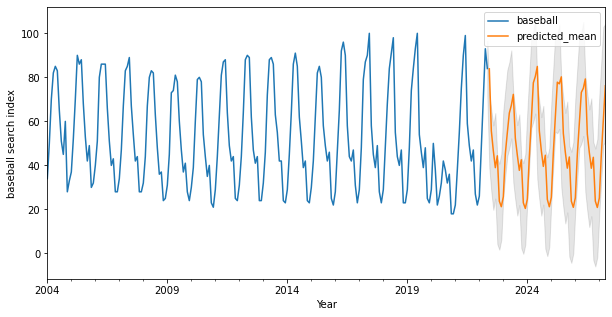

In [26]:
future_finance_forecast, next_periods_ci = forecast_with_sarimax(baseball, 60, order=(2, 0, 0),seasonal_order=(2, 1, 0,12),
                                                                 ylabel = "baseball search index", forcast_next = True)

# Q3

## A

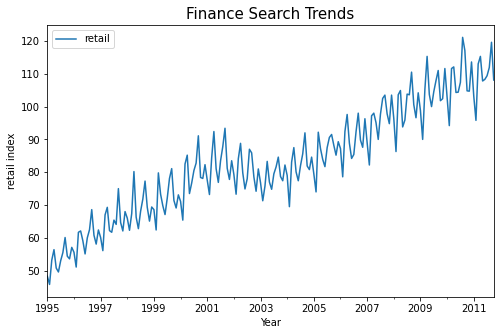

In [27]:
retail = pd.read_csv("retail.csv")
retail = preprocess_and_plot(retail, start = '1995-01-01', end = '2011-10-01',ylabel = "retail index")

we can see an uptrend with some seasonlity, lets fit hte sarima model and check how it fits the data

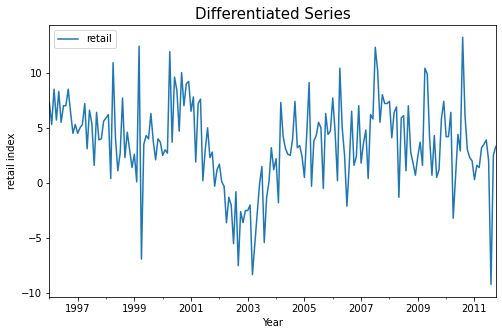

In [28]:
_ = plot_diff_series(retail, ylabel = "retail index")

In [29]:
fit_summarize_sarima(retail, (0,1,1), (0,1,1,12))

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             retail   No. Observations:                  202
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -453.669
Date:                            Wed, 14 Feb 2024   AIC                            913.338
Time:                                    13:03:36   BIC                            923.063
Sample:                                01-01-1995   HQIC                           917.278
                                     - 10-01-2011                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7060      0.052    -13.462      0.000      -0.809      -0.603
ma.S.L12      -0.7814      0.065    -11.967      0.000      -0.909      -0.653
sigma2         6.6805      0.569     11.732      0.000       5.564       7.797
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                23.46
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.47
Prob(H) (two-sided):                  0.56   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

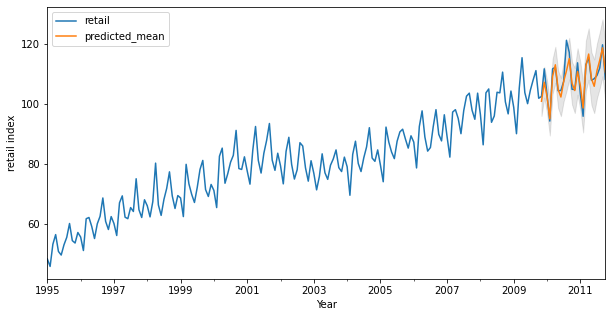

In [30]:
future_finance_forecast, next_periods_ci = forecast_with_sarimax(retail, 24, order=(0, 1, 1),seasonal_order=(0, 1, 1,12), ylabel = "retail index")

by the predicted line we can see that the model is a very good fit to the data

## B

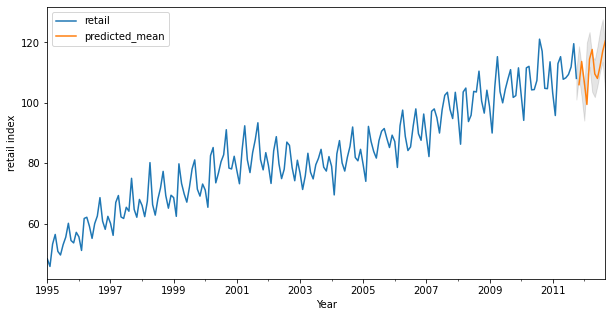

In [31]:
future_finance_forecast, next_periods_ci = forecast_with_sarimax(retail, 12, order=(0, 1, 10),seasonal_order=(0, 1, 1,12),
                                                                 forcast_next = True, ylabel = "retail index")

## C

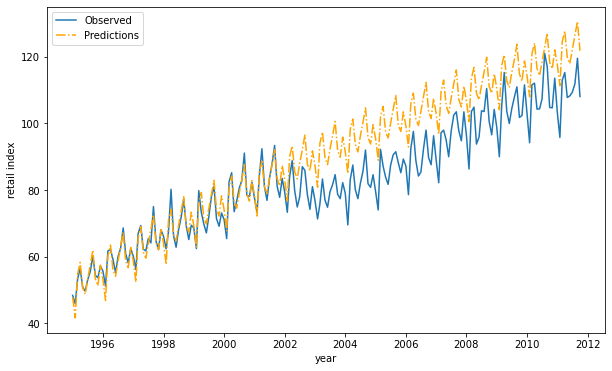

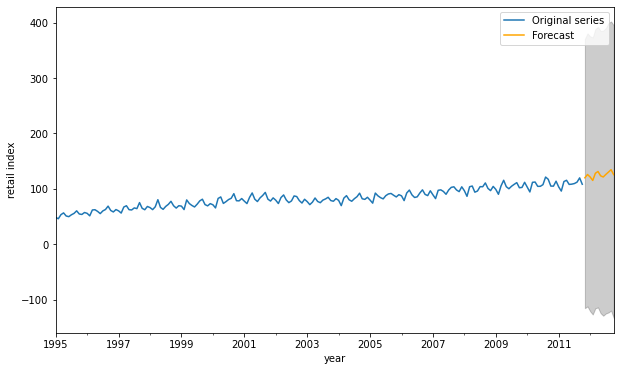

In [32]:
preds, lower_ci, upper_ci = simulate_ets_predictions(retail, "retail",
                                                     ylabel = 'retail index', xlabel="year", forecast_len = 12)

the ES does not work well here because the trend changes, prophet will probably be better.

13:03:38 - cmdstanpy - INFO - Chain [1] start processing
13:03:38 - cmdstanpy - INFO - Chain [1] done processing


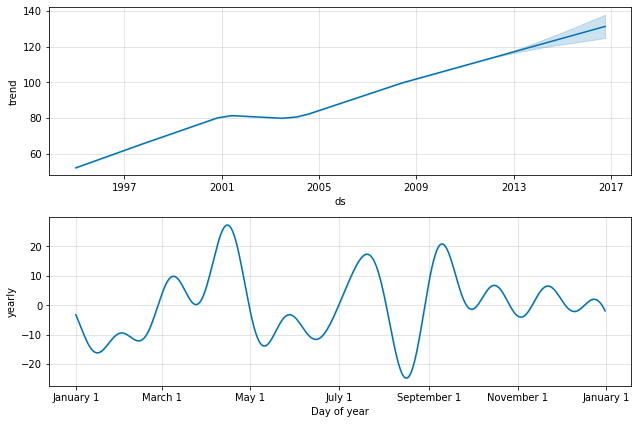

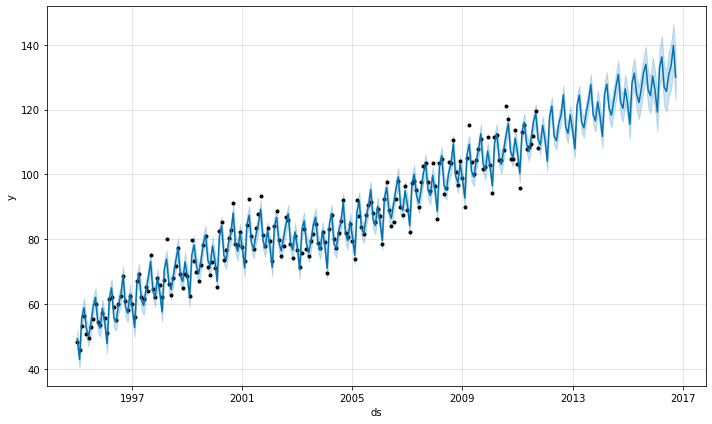

In [33]:
retail_prophet = retail.reset_index().rename({"month": "ds", "retail": "y"}, axis =1)
m = Prophet()
m.fit(retail_prophet)
future_dates = m.make_future_dataframe(periods=60, freq='MS')
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);